In [8]:
%%capture
!pip install pandas

In [7]:
%%capture
!pip install seaborn
!pip install matplotlib

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

df = pd.read_csv('day_datasets/cleaned/final_data_lag_days_3.csv')
df.head(1)

,DateTime,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,dt,Tweet_vol
0,2018-08-28 00:00:00+00:00,7027.99,5.207235,6979.853101,0.042036,0.835018,0.122955,0.226465,2018-08-28 17:29:48.290816+00:00,548.0


In [4]:
#get change label
df["Change"] = (df["Close"] > df["Close"].shift(1)).astype(int)

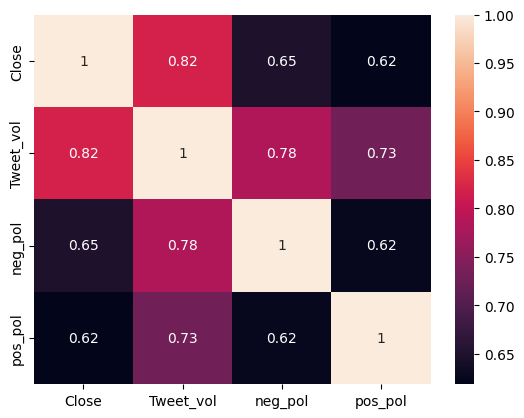

In [12]:
# plot correlation matrix
sns. (df[['Close', 'Tweet_vol', 'neg_pol', 'pos_pol']].corr(), annot=True)
plt.show()

# Splitting Dataset

In [13]:
train = df[df.DateTime <'2019-10-01']
test = df[df.DateTime >='2019-10-01']

In [14]:
test.DateTime.min(), test.DateTime.max(), train.DateTime.min(), train.DateTime.max()

('2019-10-01 00:00:00+00:00',
 '2019-11-23 00:00:00+00:00',
 '2018-08-28 00:00:00+00:00',
 '2019-09-30 00:00:00+00:00')

In [15]:
train.head(1)

,DateTime,Close,Volume_(BTC),Weighted_Price,neg_pol,neu_pol,pos_pol,compound,dt,Tweet_vol,Change
0,2018-08-28 00:00:00+00:00,7027.99,5.207235,6979.853101,0.042036,0.835018,0.122955,0.226465,2018-08-28 17:29:48.290816+00:00,548.0,0


In [32]:
from sklearn.preprocessing import MinMaxScaler
#normalise features
xscaler = MinMaxScaler(feature_range=(0, 1))
train[['Close', 'Volume_(BTC)', 'Weighted_Price', 'neg_pol', 'pos_pol', 'Tweet_vol']] = xscaler.fit_transform(train[['Close', 'Volume_(BTC)', 'Weighted_Price', 'neg_pol', 'pos_pol', 'Tweet_vol']])
test[['Close', 'Volume_(BTC)', 'Weighted_Price', 'neg_pol', 'pos_pol', 'Tweet_vol']] = xscaler.transform(test[['Close', 'Volume_(BTC)', 'Weighted_Price', 'neg_pol', 'pos_pol', 'Tweet_vol']])

/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [49]:
x_train = train[['neg_pol', 'pos_pol', 'Tweet_vol']]
x_test = test[['neg_pol', 'pos_pol', 'Tweet_vol']]
y_train = train['Change']
y_test = test['Change']

In [50]:
x_train.head(1)

,neg_pol,pos_pol,Tweet_vol
0,0.2779,0.193298,0.0


## LSTM

In [51]:
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [55]:
model = Sequential()
neurons = 64
epochs = 10000
dropout = 0.25
batch_size = 80
activ_func = "linear"

model.add(Bidirectional(LSTM(neurons, return_sequences=True, input_shape=(x_train.shape[0], x_train.shape[1]), activation=activ_func)))
model.add(Dropout(dropout))

model.add(Bidirectional(LSTM(neurons, return_sequences=False, activation=activ_func)))
model.add(Dropout(dropout))

model.add(Dense(2, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [43]:
# early stopping
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience =50)

# fit network
history = model.fit(tf.convert_to_tensor(x_train), np.array(y_train), epochs=10000, batch_size=batch_size, verbose=2, shuffle=True, callbacks=[callback])

Epoch 1/10000


ValueError: in user code:

    File "/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/keras/engine/training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/josepham/miniconda3/envs/hackathon22/lib/python3.7/site-packages/keras/engine/input_spec.py", line 233, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_4" "                 f"(type Sequential).
    
    Input 0 of layer "bidirectional_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 6)
    
    Call arguments received by layer "sequential_4" "                 f"(type Sequential):
      • inputs=tf.Tensor(shape=(None, 6), dtype=float64)
      • training=True
      • mask=None
